## Parsing unity VR log file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep
import json

from dataclasses import dataclass

In [2]:
from unityvr.preproc import logproc

In [3]:
dirName = "../sample"
fileName = "test_imaging/f02/Log_2020-8-31_19-15-6_4.json"

In [5]:
dat = logproc.openUnityLog(dirName, fileName)

#lines in document
lines = sum(1 for line in dat)

for i in range(1):
    print(dat[i]['frame'])
    print(json.dumps(dat[i]['data'], sort_keys=True, indent=4))

1.0
{
    "colliderType": "MeshCollider",
    "meshGameObjectPath": "Fly/FlyCamera3/FlyCamera3Screen",
    "worldPosition": {
        "x": 38.428314208984375,
        "y": 30.339401245117188,
        "z": -52.89203643798828
    },
    "worldRotationDegs": {
        "x": 0.0,
        "y": 324.0,
        "z": 0.0
    },
    "worldScale": {
        "x": 95.00000762939453,
        "y": 182.0,
        "z": 1.0
    }
}


In [6]:
#def loadUnityLog(dirName, fileName):

#def parseUnityLog(dat):

### Construct data object from log file
#### Pull out object positions as pandas dataframe

In [8]:
objDf = logproc.objDfFromLog(dat)
objDf

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,38.428314,-52.892036,30.339401,0.0,0.0,324.000000,95.000008,1.0,182.0
1,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,0.000000,65.378143,30.339401,0.0,0.0,180.000000,95.000000,1.0,182.0
2,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,62.178310,20.202957,30.339401,0.0,0.0,252.000000,95.000008,1.0,182.0
3,LMlocal1,CapsuleCollider,0.000000,-100.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
4,LMlocal2,CapsuleCollider,-150.000000,100.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
5,Fly/FlyCamera4/FlyCamera4Screen,MeshCollider,-38.428303,-52.892036,30.339401,0.0,0.0,35.999996,95.000000,1.0,182.0


#### Pull out fly position as pandas dataframe
Position in VR

In [9]:
posDf = logproc.posDfFromLog(dat)
posDf.head()

,frame,time,x,y,angle
0,1.0,0.000000,0.029138,-0.109734,359.992584
1,2.0,0.020000,-0.063957,-0.316354,0.053297
2,3.0,0.026142,-0.068326,-0.301990,0.091445
3,4.0,0.031466,0.317903,-0.263294,0.064798
4,5.0,0.034920,0.761612,-0.212639,359.769287


Position based on Fictrac tracking

In [10]:
ftDf = logproc.ftDfFromLog(dat)
ftDf.head()

,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,1.598916e+12,4.155843e+12,0.000000,0.000000,0.000000
1,1.0,1.598916e+12,4.155846e+12,0.001390,-0.006636,0.000422
2,1.0,1.598916e+12,4.155849e+12,-0.000424,0.005098,-0.001834
3,2.0,1.598916e+12,4.155853e+12,-0.000852,0.000028,0.000321
4,2.0,1.598916e+12,4.155856e+12,0.006246,-0.008214,0.000191


#### Generate data object

### Vizualize

#### Frame rate

#### Vizualize trajectory and object positions

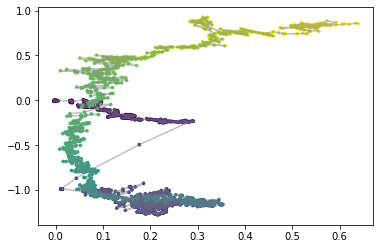

In [11]:
ballr = 45
#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

# See Seelig 2010 for reference on equations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945246/)
fta = np.cumsum(ftDf['dz'])
fty = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.cos(fta) - ballr*np.pi/180*ftDf['dx']*np.sin(fta))
ftx = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.sin(fta) + ballr*np.pi/180*ftDf['dx']*np.cos(fta))
plt.plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
plt.scatter(ftx[0:3000], fty[0:3000],s=7,c=ftDf['frame'][0:3000],cmap='viridis')

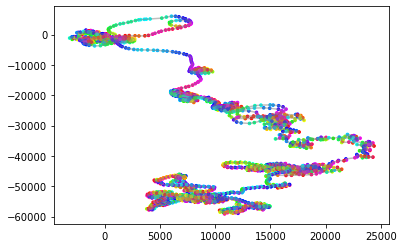

In [15]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['angle'],cmap='hsv')

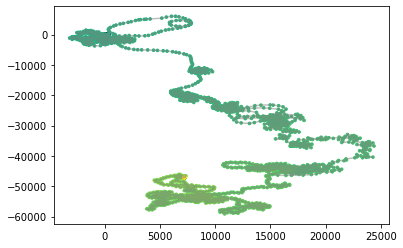

In [16]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

LMlocal1
LMlocal2


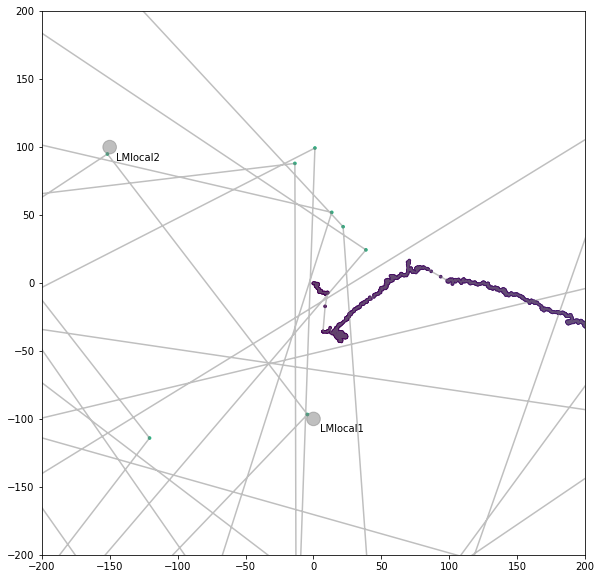

In [17]:
import matplotlib.patches as mpatches
from matplotlib import patches

minv = -200
maxv = 200

fig, ax = plt.subplots(1,1, figsize=(10,10))
for obj in range(objDf.shape[0]):
    if("FlyCamera" not in objDf.name[obj]):
        print(objDf['name'][obj])
        #ax.plot(objDf['px'][obj], objDf['py'][obj],marker='o')
        ellipse = mpatches.Ellipse((objDf['px'][obj], objDf['py'][obj]), objDf['sx'][obj], objDf['sy'][obj], color='grey', alpha=0.5)
        ax.add_patch(ellipse)
        ax.annotate(objDf['name'][obj], (objDf['px'][obj]+5, objDf['py'][obj]-10))

ax.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
ax.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')
ax.set_ylim(minv, maxv)
ax.set_xlim(minv, maxv)
ax.set_aspect('equal')

In [18]:
# Closing file 
f.close() 